## CLIP
CLIP (Contrastive Language-Image Pretraining) is a model developed by OpenAI that bridges the gap between vision and language by learning to associate images with natural language descriptions. CLIP works by training a neural network to predict which images are most relevant to a given text prompt, or conversely, which texts are most relevant to a given image. It employs a contrastive learning approach, where image and text embeddings are projected into a shared latent space. This allows CLIP to perform zero-shot learning, enabling it to generalize to unseen data without requiring labeled examples.

Key features of CLIP include:

Multimodal Learning: CLIP is trained on a diverse dataset of image-text pairs from the web, making it capable of understanding visual concepts described in language.
Zero-Shot Learning: Unlike traditional supervised learning models, CLIP can perform tasks without task-specific training, handling diverse inputs through its broad understanding of visual and textual content.
Wide Applicability: CLIP can be applied to various tasks, such as image classification, object detection, and even image-text retrieval, without requiring retraining for each new task.
CLIP is particularly useful in scenarios where labeled data is scarce, as it can generalize to new datasets and tasks using only natural language descriptions.

For more details, refer to the original paper by Radford et al. (2021), Learning Transferable Visual Models From Natural Language Supervision: Radford, A., Kim, J. W., Hallacy, C., Ramesh, A., Goh, G., Agarwal, S., ... & Sutskever, I. (2021). Learning Transferable Visual Models From Natural Language Supervision. arXiv preprint arXiv:2103.00020.

In [1]:
!pip install transformers
!pip install timm

In [150]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [272]:
class Config:
    batch_size = 32
    num_epochs = 30
    num_warmup_steps = 1000
    num_training_steps = 10000
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # I used resnet, but any model can be used
    image_encoder_model = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256
    dropout = 0.1

    batch_size = 32
    num_workers = 2

    data_dir = "/content/drive/MyDrive/Data/Flickr"
    captions_file = os.path.join(data_dir,"captions.txt")
    images_dir = os.path.join(data_dir, "Images")

    valid_size = 0.2
    test_size = 0.1
    random_seed = 42
    debug = False


In [173]:
class ImageTextDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=Config.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{Config.images_dir}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(Config.size, Config.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(Config.size, Config.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

In [170]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer
from PIL import Image
import torchvision.transforms as transforms

data = pd.read_csv(Config.captions_file, delimiter=',', names=["image", "caption"])
data['id'] = [id_ for id_ in range(data.shape[0] // 5) for _ in range(5)]
data.to_csv("captions.csv", index=False)


In [171]:
data.head(10)

,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0
5,1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting,1
6,1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with...,1
7,1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots a...,1
8,1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each o...,1
9,1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .,1


In [194]:
# Function to split the dataset into train, validation, and test sets
def make_train_valid_test_dfs(dataframe, valid_size=0.2, test_size=0.1, random_seed=42, debug=False):
    """
    Split the dataset into train, validation, and test DataFrames.

    Args:
        dataframe (pd.DataFrame): The complete dataset containing image paths and captions.
        valid_size (float): The proportion of the dataset to include in the validation split.
        test_size (float): The proportion of the dataset to include in the test split.
        random_seed (int): Seed for reproducibility of the split.
        debug (bool): If True, limit the dataset for quick testing.

    Returns:
        train_df (pd.DataFrame): Training data.
        valid_df (pd.DataFrame): Validation data.
        test_df (pd.DataFrame): Test data.
    """
    max_id = dataframe["id"].max() + 1
    if debug:
        max_id = 100  # Use a smaller dataset in debug mode

    # Get unique image ids
    image_ids = np.arange(0, max_id)

    # First split into train+valid and test
    train_valid_ids, test_ids = train_test_split(image_ids, test_size=test_size, random_state=random_seed)

    # Further split train+valid into train and valid
    train_ids, valid_ids = train_test_split(train_valid_ids, test_size=valid_size/(1 - test_size), random_state=random_seed)

    # Filter the dataframe based on the split ids
    train_df = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_df = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    test_df = dataframe[dataframe["id"].isin(test_ids)].reset_index(drop=True)

    return train_df, valid_df, test_df

# Function to build DataLoaders
def build_loaders(dataframe, tokenizer, mode, batch_size, num_workers):
    """
    Build PyTorch DataLoaders for train, validation, or test sets.

    Args:
        dataframe (pd.DataFrame): DataFrame containing image paths and captions.
        tokenizer: The tokenizer to convert captions to tokens.
        mode (str): 'train', 'valid', or 'test', controls the data augmentation and shuffling.
        batch_size (int): Number of samples per batch.
        num_workers (int): Number of subprocesses to use for data loading.

    Returns:
        DataLoader: The PyTorch DataLoader for the dataset.
    """
    # Get appropriate transforms (augmentations)
    transforms = get_transforms(mode=mode)  # Assuming `get_transforms()` is defined

    # Create the dataset
    dataset = ImageTextDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )

    # Create the DataLoader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True if mode == "train" else False,  # Shuffle only for training
        pin_memory=True  # Speeds up data transfer to GPU
    )

    return dataloader

# Load dataset
dataframe = pd.read_csv('/content/captions.csv')

# Split into train, valid, and test DataFrames
train_df, valid_df, test_df = make_train_valid_test_dfs(
        dataframe,
        valid_size=Config.valid_size,
        test_size=Config.test_size,
        random_seed=Config.random_seed,
        debug=Config.debug
    )

    # Assuming tokenizer is defined
tokenizer = DistilBertTokenizer.from_pretrained(Config.text_tokenizer)

# Build DataLoaders for train, valid, and test
train_loader = build_loaders(train_df, tokenizer, mode="train", batch_size=Config.batch_size, num_workers=Config.num_workers)
val_loader = build_loaders(valid_df, tokenizer, mode="valid", batch_size=Config.batch_size, num_workers=Config.num_workers)
test_loader = build_loaders(test_df, tokenizer, mode="test", batch_size=Config.batch_size, num_workers=Config.num_workers)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [273]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50
from torchvision.models import resnet101
from transformers import BertModel, BertTokenizer
import timm

class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=Config.projection_dim,
        dropout=Config.dropout
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)

    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

# Vision Encoder (ResNet backbone)
class VisionEncoder(nn.Module):
    def __init__(self, image_embed = Config.image_embedding, embed_dim=Config.projection_dim):
        super(VisionEncoder, self).__init__()
        self.model = timm.create_model(
            Config.image_encoder_model, True, num_classes=0, global_pool="avg"
        )
        self.projection_head = ProjectionHead(image_embed, embed_dim)

    def forward(self, images):
        features = self.model(images)
        embeddings = self.projection_head(features)
        return embeddings

# Text Encoder (BERT backbone)
class TextEncoder(nn.Module):
    def __init__(self, text_embed=Config.text_embedding, embed_dim=Config.projection_dim):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained(Config.text_encoder_model)
        self.projection_head = ProjectionHead(text_embed, embed_dim)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        text_embeddings = self.projection_head(outputs.pooler_output)  # Project to same dim as images
        return text_embeddings

class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1.0,
    ):
        super().__init__()
        self.vision_encoder = VisionEncoder()
        self.text_encoder = TextEncoder()
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_embeddings = self.vision_encoder(batch["image"])
        text_embeddings = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()


In [274]:
def train(model, train_loader, val_loader, optimizer, scheduler, device, epochs=10):
    model.to(device)

    best_val_loss = float('inf')

    for epoch in range(epochs):
        # Training loop
        model.train()
        total_train_loss = 0.0

        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as tqdm_loader:
            for batch in tqdm_loader:
                batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}

                # Forward pass
                optimizer.zero_grad()
                loss = model(batch)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()
                tqdm_loader.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            with tqdm(val_loader, desc="Validating") as val_tqdm:
                for batch in val_tqdm:
                    batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
                    # Forward pass
                    val_loss = model(batch)
                    total_val_loss += val_loss.item()

                    val_tqdm.set_postfix(val_loss=val_loss.item())

        avg_val_loss = total_val_loss / len(val_loader)

        # Save the model if validation loss decreases
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_clip_model.pth')
            print(f"Model saved with Val Loss: {best_val_loss:.4f}")

        # Step scheduler
        scheduler.step(avg_val_loss)

        # Print summary
        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


In [276]:
# Run the training
import itertools
from transformers import BertTokenizer
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.autonotebook import tqdm

load_pretrained = False
model = CLIPModel()
if load_pretrained:
    model.load_state_dict(torch.load('/content/drive/MyDrive/Model/Clip/clip_model_best.pth'))
params = [
        {"params": model.vision_encoder.model.parameters(), "lr": Config.image_encoder_lr},
        {"params": model.text_encoder.bert.parameters(), "lr": Config.text_encoder_lr},
        {"params": itertools.chain(
            model.vision_encoder.projection_head.parameters(), model.text_encoder.projection_head.parameters()
        ), "lr": Config.head_lr, "weight_decay": Config.weight_decay}
    ]
optimizer = torch.optim.Adam(params, weight_decay=Config.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=Config.patience, factor=Config.factor
    )
train(model, train_loader, val_loader, optimizer, lr_scheduler, Config.device, Config.num_epochs)

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertModel were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.inte

Epoch 1/30:   0%|          | 0/885 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Model saved with Val Loss: 3.4676
Epoch [1/30] | Train Loss: 3.8255 | Val Loss: 3.4676


Epoch 2/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Model saved with Val Loss: 2.9626
Epoch [2/30] | Train Loss: 3.0656 | Val Loss: 2.9626


Epoch 3/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Model saved with Val Loss: 2.6488
Epoch [3/30] | Train Loss: 2.4318 | Val Loss: 2.6488


Epoch 4/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Model saved with Val Loss: 2.4526
Epoch [4/30] | Train Loss: 1.6578 | Val Loss: 2.4526


Epoch 5/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Model saved with Val Loss: 2.4281
Epoch [5/30] | Train Loss: 1.2188 | Val Loss: 2.4281


Epoch 6/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Model saved with Val Loss: 2.4162
Epoch [6/30] | Train Loss: 0.9478 | Val Loss: 2.4162


Epoch 7/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [7/30] | Train Loss: 0.7801 | Val Loss: 2.4462


Epoch 8/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Model saved with Val Loss: 2.3471
Epoch [8/30] | Train Loss: 0.6610 | Val Loss: 2.3471


Epoch 9/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [9/30] | Train Loss: 0.5934 | Val Loss: 2.5138


Epoch 10/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [10/30] | Train Loss: 0.5303 | Val Loss: 2.3808


Epoch 11/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [11/30] | Train Loss: 0.4299 | Val Loss: 2.4519


Epoch 12/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [12/30] | Train Loss: 0.4012 | Val Loss: 2.4817


Epoch 13/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [13/30] | Train Loss: 0.3261 | Val Loss: 2.5758


Epoch 14/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [14/30] | Train Loss: 0.3205 | Val Loss: 2.5702


Epoch 15/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [15/30] | Train Loss: 0.2745 | Val Loss: 2.5953


Epoch 16/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [16/30] | Train Loss: 0.2627 | Val Loss: 2.6422


Epoch 17/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [17/30] | Train Loss: 0.2216 | Val Loss: 2.6355


Epoch 18/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [18/30] | Train Loss: 0.2123 | Val Loss: 2.6774


Epoch 19/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [19/30] | Train Loss: 0.1924 | Val Loss: 2.7184


Epoch 20/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [20/30] | Train Loss: 0.1828 | Val Loss: 2.7717


Epoch 21/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [21/30] | Train Loss: 0.1656 | Val Loss: 2.8608


Epoch 22/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [22/30] | Train Loss: 0.1618 | Val Loss: 2.8504


Epoch 23/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [23/30] | Train Loss: 0.1430 | Val Loss: 2.9635


Epoch 24/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [24/30] | Train Loss: 0.1391 | Val Loss: 2.9424


Epoch 25/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [25/30] | Train Loss: 0.1328 | Val Loss: 2.9307


Epoch 26/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [26/30] | Train Loss: 0.1221 | Val Loss: 3.0094


Epoch 27/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [27/30] | Train Loss: 0.1214 | Val Loss: 2.9892


Epoch 28/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [28/30] | Train Loss: 0.1142 | Val Loss: 2.9728


Epoch 29/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [29/30] | Train Loss: 0.1013 | Val Loss: 3.0429


Epoch 30/30:   0%|          | 0/885 [00:00<?, ?it/s]

Validating:   0%|          | 0/253 [00:00<?, ?it/s]

Epoch [30/30] | Train Loss: 0.1068 | Val Loss: 3.0702


In [81]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Model/Clip/clip_model_best.pth')

In [198]:
model = CLIPModel()
model.load_state_dict(torch.load('best_clip_model.pth'))
model.eval()
def evaluate(model, test_loader, tokenizer, device):
    model.to(device)
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}
            # Forward pass
            loss = model(batch) # Pass the batch dictionary to the model
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

    return avg_test_loss

# Run the evaluation
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
evaluate(model, test_loader, tokenizer, Config.device)


<ipython-input-198-87b437c8dafe>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_clip_model.pth'))
/usr/local/lib/python3.10/dist-pac

Test Loss: 2.8377


2.837676097088911

Now let us text for retrieval

In [200]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

# Load the model (if not already loaded)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Precompute image embeddings for your validation set (if not already done)
def precompute_image_embeddings(model, image_paths):
    transform = Compose([
        Resize(224, interpolation=Image.BICUBIC),
        CenterCrop(224),
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])

    embeddings = []
    for path in image_paths:
        path = f'{Config.images_dir}/{path}'
        image = transform(Image.open(path)).unsqueeze(0).to(device)
        with torch.no_grad():
            embedding = model.vision_encoder(image)
        embeddings.append(embedding)

    return torch.cat(embeddings)

image_embeddings = precompute_image_embeddings(model, test_df['image'].values)


In [263]:
def fetch_relevant_images(model, image_embeddings, text_query, image_paths, top_k=9):
    # Ensure the model is in evaluation mode
    model.eval()

    # Initialize tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained(Config.text_tokenizer)

    # Tokenize the query
    encoded_query = tokenizer([text_query])

    batch = {
        key: torch.tensor(values).to(Config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_embeddings = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

    # Normalize the embeddings
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)

    similarity = text_embeddings_n @ image_embeddings_n.T
    #similarity = similarity.squeeze(0)

    values, indices = torch.topk(similarity.squeeze(0), k = 5*top_k)

    matches = [image_paths[idx] for idx in indices[::5]]

    _, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image_path = f"{Config.images_dir}/{match}"
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.show()


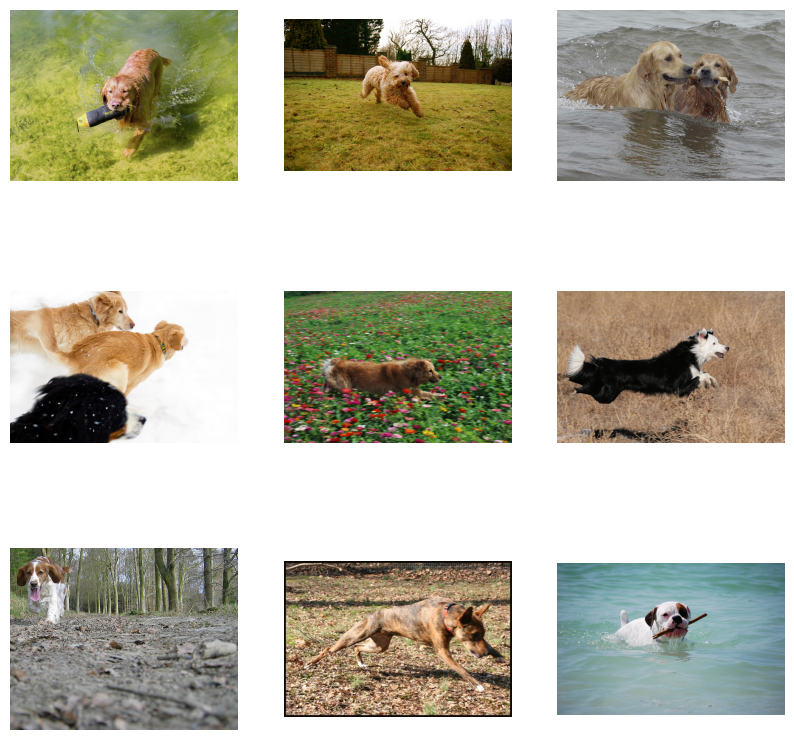

In [264]:
# Now you can use the function
text_query = "dog playing"
fetch_relevant_images(model, image_embeddings, text_query, test_df['image'].values)